# Traffic Prediction:
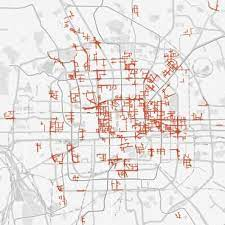

Traffic is one of those annoying problems that affect many of us living in urban settings. One of the causes of traffic is the increase in urban populations. While the infrastructure is old and can only accommodate a limited population there is an influx of residents in search of livelihood and opportunities.

In this project, I will be exploring four datasets, primary goal is to predict the "Total Carriageway Flow" for the upcoming week, with a 15-minute interval granularity.

**Table Of Contents**

1. IMPORTING LIBRARIES

2. LOADING DATA

3. DATA EXPLORATION
- FEATURE ENGINEERING
- EXPLORATORY DATA ANALYSIS

4. DATA TRANSFORMATION AND PREPROCESSING
- Pharsing dates
- Dealing with NaN values
- Categorical data

5. Normalize the data

6. Data windowing

7. TimeSeries Generator

8. MODEL BUILDING

9. FITTING THE MODEL

10. Prediction


# Importing Libraries

In [ ]:
# Importing Libraries

import datetime
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras import callbacks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator


import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Challenge_Files.zip to Challenge_Files.zip


In [ ]:
!unzip "/content/Challenge_Files.zip" -d "/content/dataset/"

Archive:  /content/Challenge_Files.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/__MACOSX/._sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/__MACOSX/._test.csv  
  inflating: /content/dataset/traffic.csv  
  inflating: /content/dataset/__MACOSX/._traffic.csv  
  inflating: /content/dataset/weather.csv  
  inflating: /content/dataset/__MACOSX/._weather.csv  


Dataset Description

Here we present the traffic and weather data for January 2016. The weather dataset comprises hourly data, while the traffic data is recorded at 15-minute intervals. Feel free to clean and refine the data according to your preferences, and the decision to include or exclude specific features is entirely at your discretion.


In [ ]:
#Loading Data
# traffic_data = pd.read_csv('/content/dataset/traffic.csv', parse_dates=['Local Date',' Local Time'], index_col=None)

traffic_data = pd.read_csv('/content/dataset/traffic.csv', index_col=None)
weather_data = pd.read_csv('/content/dataset/weather.csv', index_col=None)
test_data = pd.read_csv('/content/dataset/test.csv', index_col=None)
sample= pd.read_csv('/content/dataset/sample_submission.csv', index_col=None)

In [ ]:
# We are going to use traffic_data dataset for prediction
traffic_data.head()

,Local Date,Local Time,Total Carriageway Flow,Total Flow vehicles less than 5.2m,Total Flow vehicles 5.21m - 6.6m,Total Flow vehicles 6.61m - 11.6m,Total Flow vehicles above 11.6m,Speed Value
0,2016-01-01,00:14:00,11,10,0,0,1,108.38
1,2016-01-01,00:29:00,26,20,1,2,3,106.22
2,2016-01-01,00:44:00,43,41,1,1,0,107.60
3,2016-01-01,00:59:00,60,55,1,2,2,108.58
4,2016-01-01,01:14:00,54,50,2,1,1,106.29


In [ ]:
# The training data
weather_data.head()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2016-01-01T00:00:00,4.0,0.9,2.7,91.68,0.393,100,rain,0.0,0.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
1,2016-01-01T01:00:00,3.0,0.0,2.2,94.54,0.000,0,NaN,0.0,0.0,...,233,1020.2,0.0,11.4,NaN,NaN,NaN,NaN,Clear,clear-night
2,2016-01-01T02:00:00,2.5,-0.4,1.8,95.73,0.000,0,NaN,0.0,0.0,...,213,1021.0,0.0,11.6,NaN,NaN,NaN,NaN,Clear,clear-night
3,2016-01-01T03:00:00,1.7,-0.8,1.1,95.30,0.000,0,NaN,0.0,0.0,...,221,1021.8,0.0,11.2,NaN,NaN,NaN,NaN,Clear,clear-night
4,2016-01-01T04:00:00,0.7,0.7,0.2,96.38,0.000,0,NaN,0.0,0.0,...,151,1021.7,0.0,10.6,NaN,NaN,NaN,NaN,Clear,clear-night


In [ ]:
# The test data
test_data.head()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2016-02-01T00:00:00,12.2,12.2,11.6,96.03,0.016,100,rain,0,0,...,246,1009.4,90.4,10.1,NaN,NaN,NaN,NaN,"Rain, Overcast",rain
1,2016-02-01T01:00:00,12.1,12.1,11.3,94.67,0.000,0,NaN,0,0,...,247,1010.3,95.7,10.3,NaN,NaN,NaN,NaN,Overcast,cloudy
2,2016-02-01T02:00:00,12.1,12.1,11.1,93.38,0.000,0,NaN,0,0,...,250,1010.8,93.0,10.4,NaN,NaN,NaN,NaN,Overcast,cloudy
3,2016-02-01T03:00:00,12.1,12.1,10.8,91.46,0.000,0,NaN,0,0,...,237,1011.1,88.2,10.7,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night
4,2016-02-01T04:00:00,12.1,12.1,10.5,89.90,0.000,0,NaN,0,0,...,237,1011.3,93.0,10.8,NaN,NaN,NaN,NaN,Overcast,cloudy


In [ ]:
# And the task is to generate prediction like this-
sample.head()

,Local Date,Local Time,Total Carriageway Flow
0,2016-02-01,00:14:00,11
1,2016-02-01,00:29:00,26
2,2016-02-01,00:44:00,43
3,2016-02-01,00:59:00,60
4,2016-02-01,01:14:00,54


# Data Exploration: traffic dataset
1. Remove these features'Total Flow vehicles less than 5.2m', 'Total Flow vehicles 5.21m - 6.6m', 'Total Flow vehicles 6.61m - 11.6m', 'Total Flow vehicles above 11.6m', 'Speed Value'.
2. Convert Local Date and Local Time as datetime type.
3. Data manipulation and transformation
4. Raw Data Visualization: To give us a sense of the data we are working with,Ploting distributions and time-series.


In [ ]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Local Date                          2976 non-null   object 
 1    Local Time                         2976 non-null   object 
 2    Total Carriageway Flow             2976 non-null   int64  
 3   Total Flow vehicles less than 5.2m  2976 non-null   int64  
 4   Total Flow vehicles 5.21m - 6.6m    2976 non-null   int64  
 5   Total Flow vehicles 6.61m - 11.6m   2976 non-null   int64  
 6   Total Flow vehicles above 11.6m     2976 non-null   int64  
 7    Speed Value                        2976 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 186.1+ KB


In [ ]:
# first version of traffic data
ogg=traffic_data.copy()

# converting the 'Local Date' and 'Local Time' columns to datetime objects
ogg['Local Date'] = pd.to_datetime(ogg['Local Date'])
ogg['Local Time'] = pd.to_timedelta(ogg[' Local Time'])

# constructing new features: Local Date + Local Time -> datetime to use it as index.
ogg['date time'] = ogg['Local Date'] + ogg['Local Time']

ogg['datetime'] = pd.to_datetime(ogg.pop('date time'), format='%y.%m.%d %H:%M:%S')

# Remove redundant features
ogg.drop(columns=[' Local Time',' Speed Value','Total Flow vehicles less than 5.2m','Total Flow vehicles 5.21m - 6.6m','Total Flow vehicles 6.61m - 11.6m','Total Flow vehicles above 11.6m'], axis=1, inplace=True)
ogg.head()

,Local Date,Total Carriageway Flow,Local Time,datetime
0,2016-01-01,11,0 days 00:14:00,2016-01-01 00:14:00
1,2016-01-01,26,0 days 00:29:00,2016-01-01 00:29:00
2,2016-01-01,43,0 days 00:44:00,2016-01-01 00:44:00
3,2016-01-01,60,0 days 00:59:00,2016-01-01 00:59:00
4,2016-01-01,54,0 days 01:14:00,2016-01-01 01:14:00


**Pharsing Date and Time**

In [ ]:
#second version
sample_df=traffic_data.copy()

# converting the 'Local Date' and 'Local Time' columns to datetime objects
sample_df['Local Date'] = pd.to_datetime(sample_df['Local Date'])
sample_df['Local Time'] = pd.to_timedelta(sample_df[' Local Time'])

# constructing new features: Local Date + Local Time -> datetime to use it as index.
sample_df['date time'] = sample_df['Local Date'] + sample_df['Local Time']

sample_df['datetime'] = pd.to_datetime(sample_df.pop('date time'), format='%y.%m.%d %H:%M:%S')

#Separate dates for future plotting
train_dates = sample_df['datetime']

# set datetime as index
sample_df.index = sample_df['datetime']

# Remove redundant features
sample_df.drop(columns=['Local Time','Local Date','datetime', ' Local Time',' Speed Value','Total Flow vehicles less than 5.2m','Total Flow vehicles 5.21m - 6.6m','Total Flow vehicles 6.61m - 11.6m','Total Flow vehicles above 11.6m'], axis=1, inplace=True)
sample_df.head()

,Total Carriageway Flow
datetime,
2016-01-01 00:14:00,11
2016-01-01 00:29:00,26
2016-01-01 00:44:00,43
2016-01-01 00:59:00,60
2016-01-01 01:14:00,54


In [ ]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2976 entries, 2016-01-01 00:14:00 to 2016-01-31 23:59:00
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0    Total Carriageway Flow  2976 non-null   int64
dtypes: int64(1)
memory usage: 46.5 KB


# Weather data Exploration: Building a training dataset
- EDA
- Correlation matrix
- Data visualisation

- Dealing with NaN values
- Dealing with categorical variables
- Data manipulation and transformation

In [ ]:
# making an copy
train_df=weather_data.copy()

**Here is the evolution of a few features over time**

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2016-01-01T00:00:00,4.0,0.9,2.7,91.68,0.393,100,rain,0.0,0.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
1,2016-01-01T01:00:00,3.0,0.0,2.2,94.54,0.000,0,NaN,0.0,0.0,...,233,1020.2,0.0,11.4,NaN,NaN,NaN,NaN,Clear,clear-night
2,2016-01-01T02:00:00,2.5,-0.4,1.8,95.73,0.000,0,NaN,0.0,0.0,...,213,1021.0,0.0,11.6,NaN,NaN,NaN,NaN,Clear,clear-night
3,2016-01-01T03:00:00,1.7,-0.8,1.1,95.30,0.000,0,NaN,0.0,0.0,...,221,1021.8,0.0,11.2,NaN,NaN,NaN,NaN,Clear,clear-night
4,2016-01-01T04:00:00,0.7,0.7,0.2,96.38,0.000,0,NaN,0.0,0.0,...,151,1021.7,0.0,10.6,NaN,NaN,NaN,NaN,Clear,clear-night


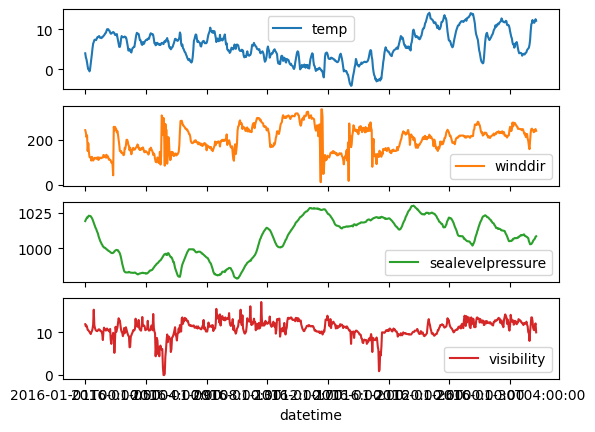

In [ ]:
plot_cols = ['temp', 'winddir', 'sealevelpressure','visibility','conditions']
plot_features = train_df[plot_cols]
plot_features.index = train_df['datetime']
_ = plot_features.plot(subplots=True)
train_df.head()

In [ ]:
# look at the statistics of the dataset:

train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,744.0,5.823522,3.783996,-4.10,3.2000,6.000,8.225,14.100
feelslike,744.0,3.138575,4.679583,-6.50,-0.3000,2.700,5.600,14.100
dew,744.0,4.141801,3.996659,-4.60,0.7000,4.500,7.200,13.200
humidity,744.0,89.400712,9.238325,58.08,83.1125,91.825,97.215,100.000
precip,744.0,0.080847,0.384558,0.00,0.0000,0.000,0.000,5.602
precipprob,744.0,16.532258,37.172133,0.00,0.0000,0.000,0.000,100.000
snow,744.0,0.001358,0.037028,0.00,0.0000,0.000,0.000,1.010
snowdepth,744.0,0.040081,0.183248,0.00,0.0000,0.000,0.000,1.010
windgust,196.0,54.950000,7.739208,42.50,48.2000,53.200,60.250,81.700
windspeed,744.0,19.262231,10.596614,0.10,12.0000,18.250,25.200,55.700


A Correlation Matrix for understanding the relationships and strengths of association between multiple variables:

- The number in each cell represents the strength and direction of the correlation
- Positive numbers indicating positive correlations (when one variable increases, the other variable tends to increase)
- Negative numbers indicating negative correlations (when one variable increases, the other variable tends to decrease).

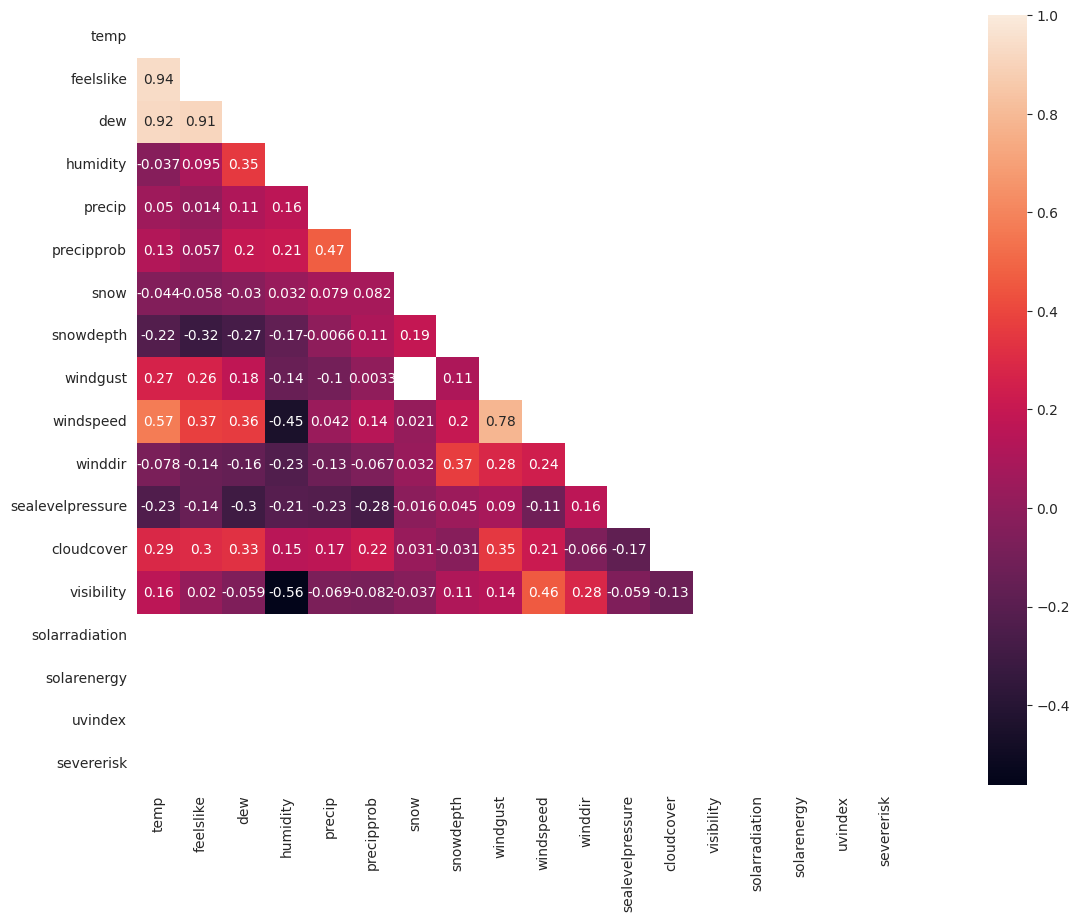

In [ ]:
# Compute the correlation matrix
corr=train_df.corr()

mask=np.zeros_like(corr)

# Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)]=True

# Plot
with sns.axes_style("white"):
    f, ax=plt.subplots(figsize=(21,10))
    ax=sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True)

From the above plot following things can be concluded:

- We can see from the correlation heatmap, few parameters like Dew and Humidity are redundant

- an correlation between:
1. The relationship between the atmospheric pressure (Dew, humidity) and the temperature is directly proportional to each other.
2. wind features and visibility.
3. Temperature and wind features
4. wind features and Snow  

which indicates that they’re strongly positively correlated.

In [ ]:
train_df.head()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon
0,2016-01-01T00:00:00,4.0,0.9,2.7,91.68,0.393,100,rain,0.0,0.0,...,244,1019.2,0.0,11.9,NaN,NaN,NaN,NaN,Rain,rain
1,2016-01-01T01:00:00,3.0,0.0,2.2,94.54,0.000,0,NaN,0.0,0.0,...,233,1020.2,0.0,11.4,NaN,NaN,NaN,NaN,Clear,clear-night
2,2016-01-01T02:00:00,2.5,-0.4,1.8,95.73,0.000,0,NaN,0.0,0.0,...,213,1021.0,0.0,11.6,NaN,NaN,NaN,NaN,Clear,clear-night
3,2016-01-01T03:00:00,1.7,-0.8,1.1,95.30,0.000,0,NaN,0.0,0.0,...,221,1021.8,0.0,11.2,NaN,NaN,NaN,NaN,Clear,clear-night
4,2016-01-01T04:00:00,0.7,0.7,0.2,96.38,0.000,0,NaN,0.0,0.0,...,151,1021.7,0.0,10.6,NaN,NaN,NaN,NaN,Clear,clear-night


In [ ]:
train_df.isnull().values.ravel().sum()

4145

# Handle Missing Values in Time Series

In time series data, if there are missing values, there are few ways to deal with the incomplete data:

- Imputation methods: Impute the missing information
- Deletion methods: omit the entire record that contains information
- Model-based methods: use machine learning models to handle missing information.

Since the time series data has temporal property, only some of the statistical methodologies are appropriate for time series data.

Before talking about the imputation methods, let’s classify the time series data according to the composition.
If we decomposite the time series data with linear regression model, it is:

**Yt=mt+st+ϵt**

where

 mt stands for trend,

  st stands for seasonality,
 and

  ϵt stands for random variables

- Based on the equation above, there can be four types of time series data:
1. no trend or seasonality (fig1)
2. has trend, but no seasonality (fig2)
3. has seasonality, but no trend (fig3)
4. has both trend and seasonality (fig4)

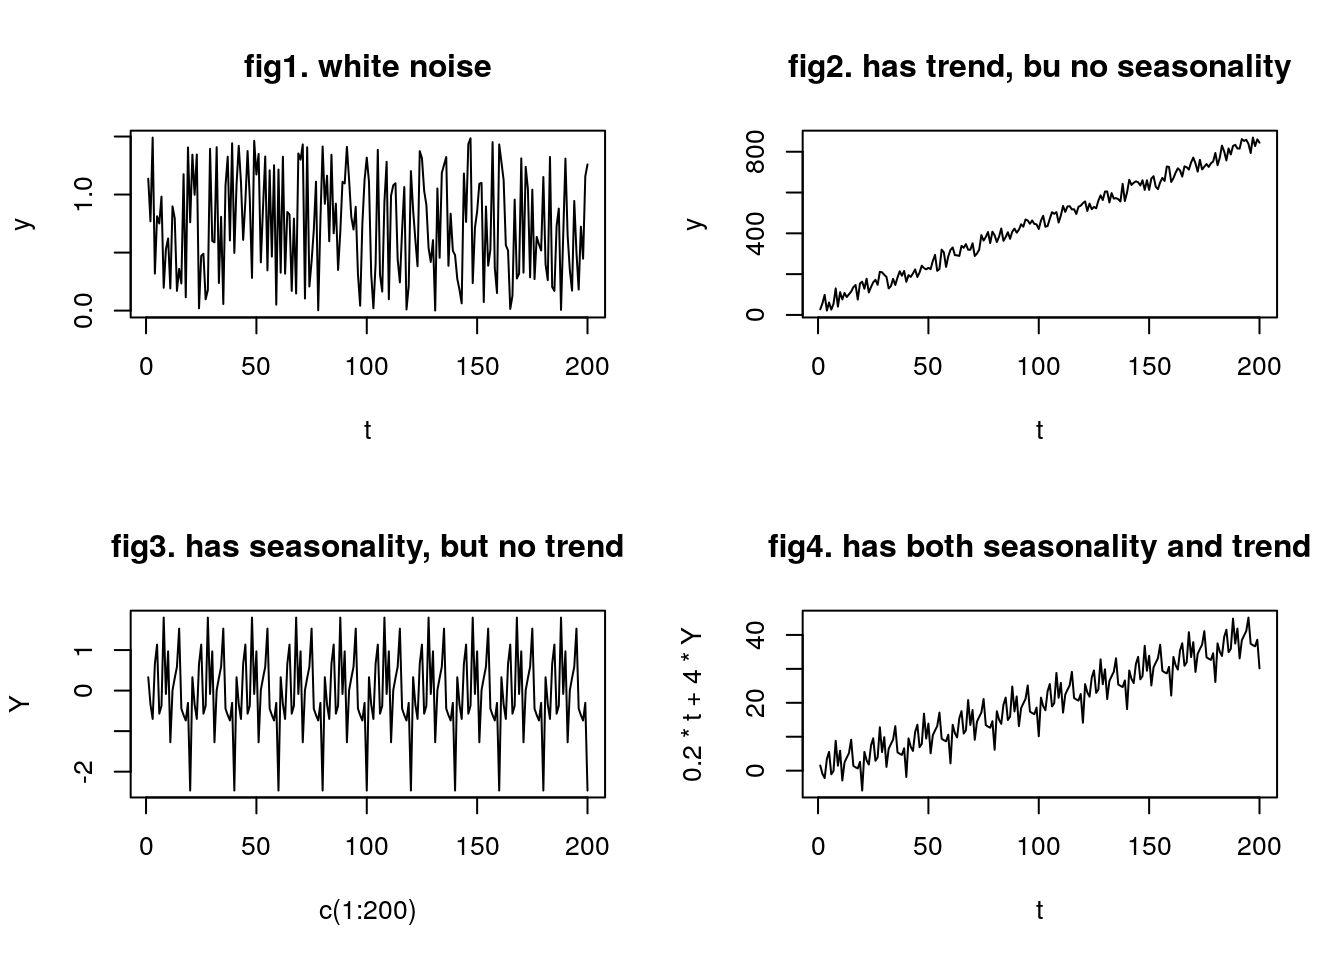

# A bit of theory on missing values in time series data:

1. **Imputation:** Here we replace missing values with some estimates based on the available data.

There are 2 ways we can impute nan values:-
- 1. Univariate Imputation: We use the feature itself that has nan values to impute the nan values. Techniques include mean/median/mode imputation, although there is a catch, with these techniques as they distort the distribution of the feature.
- Other  methods can be **last observation carried forward (LOCF)** or **next observation carried backward (NOCB)**, which replaces missing values with the last or next observed value in the same time series. Or ** Linear interpolation** is also an option,which replaces missing values with a linear function that connects the nearest observed values in the same time series.

- 2. Multivariate Imputation:Here we use multiple columns to impute nan values in a specific feature/column.
- This method is the most preferred as it results in better imputation results than Univariate Imputation.

- Some of the most used techniques are, KNNImputer based on k-nearest neighbors (KNN), IterativeImputer, expectation-maximization (EM), or matrix factorization, can be used to estimate missing values based on patterns and correlations in the data.

- **Disadvantage** with imputation approch: They can also introduce bias, reduce variability, and ignore the temporal structure of the data.

2. **Deletion**: Here we remove missing values or entire observations containing them from the data.
- Although deletion methods are simple and can avoid adding noise or distortion to the data,
- they also have some drawbacks, such as reducing the sample size, losing information, or creating bias.

3. **Model-based methods**: Here we can use Missing indicator and we could explore few approches like Missing at Random (MAR), and Missing not at Random (MNAR) are some of the common model-based methods. These methods are flexible and can account for uncertainty and complexity of missing data, although they require more computational resources, make more assumptions, or are sensitive to model specification.

**The best strategy** for handling missing data in time series datasets depends on the nature, extent, and pattern of the missing data, as well as the goal and context of the analysis. Therefore, in this project I have explored all the above three approches to understand the data before applying any strategy to evaluate the impact on the performance and validity of models.

**In most cases**, dropping data only makes sense when you have a large number of NaN values. But if there are reasonable number of NaN values, then the best option is to try to impute them.

**Bottom line** being, only drop NaN values when feature has a majority of it's values as NaN. If not, it's usually better to impute.


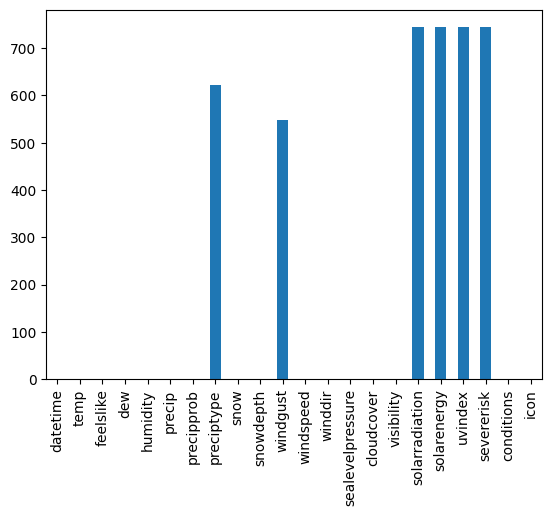

In [ ]:
train_df.isna().sum().plot(kind="bar")
plt.show()

As is evident from above fig. removing the missing values from these 6 features is the best way forward, as NaN values in these six feature has a majority of it's values as NaN, and it is not going to be of much use to any algorithm. Also imputing these feature is not going to work as we don't have much data to go on with.

**Dealing with Nan data**

In [ ]:
# Nan values
train_df = train_df.replace('NaN', pd.NA).dropna(axis=1)

print(train_df .isnull().sum())

datetime            0
temp                0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
snow                0
snowdepth           0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
conditions          0
icon                0
dtype: int64


In [ ]:
train_df.head()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,icon
0,2016-01-01T00:00:00,4.0,0.9,2.7,91.68,0.393,100,0.0,0.0,12.4,244,1019.2,0.0,11.9,Rain,rain
1,2016-01-01T01:00:00,3.0,0.0,2.2,94.54,0.000,0,0.0,0.0,10.9,233,1020.2,0.0,11.4,Clear,clear-night
2,2016-01-01T02:00:00,2.5,-0.4,1.8,95.73,0.000,0,0.0,0.0,10.3,213,1021.0,0.0,11.6,Clear,clear-night
3,2016-01-01T03:00:00,1.7,-0.8,1.1,95.30,0.000,0,0.0,0.0,8.5,221,1021.8,0.0,11.2,Clear,clear-night
4,2016-01-01T04:00:00,0.7,0.7,0.2,96.38,0.000,0,0.0,0.0,4.1,151,1021.7,0.0,10.6,Clear,clear-night


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          744 non-null    object 
 1   temp              744 non-null    float64
 2   feelslike         744 non-null    float64
 3   dew               744 non-null    float64
 4   humidity          744 non-null    float64
 5   precip            744 non-null    float64
 6   precipprob        744 non-null    int64  
 7   snow              744 non-null    float64
 8   snowdepth         744 non-null    float64
 9   windspeed         744 non-null    float64
 10  winddir           744 non-null    int64  
 11  sealevelpressure  744 non-null    float64
 12  cloudcover        744 non-null    float64
 13  visibility        744 non-null    float64
 14  conditions        744 non-null    object 
 15  icon              744 non-null    object 
dtypes: float64(11), int64(2), object(3)
memory u

Noticeable information-

- Here we will convert datetime (string) object to datetime object and set this as index.

- We can drop either conditions or icon features, as both would be redundant. And Convert categorical data into numerical data, i.e., (Rain, Overcast) into (1 or 0 / 1,2,3...).

**Dealing with categorical variables:**

partly-cloudy-night    159
cloudy                 147
clear-night            137
rain                   122
partly-cloudy-day       99
clear-day               76
fog                      2
wind                     1
snow                     1
Name: icon, dtype: int64


<Axes: ylabel='icon'>

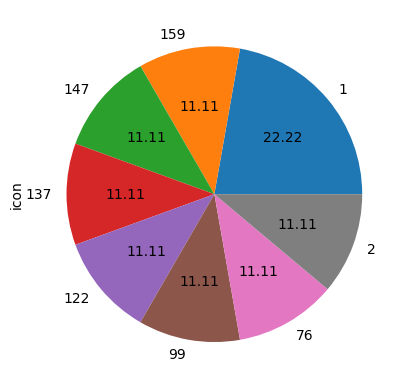

In [ ]:
# find the frequency counts of column 'conditions' and 'icon' in the data frame

conditions=train_df['conditions'].value_counts()
icon=train_df['icon'].value_counts()

print(icon)
icon.value_counts().plot.pie(autopct='%.2f')

Noticeable information in the above plot:

Data in the icon feature is not imbalanced
We could implement encoding method like LabelEncoder, OneHotEncoder, or Dummy Variables to convert categorical data into numerical data, suitable for ML modelling.

**Encoder to transform categorical data into integers:**

In [ ]:
# Remove features
train_df.drop(columns=['conditions'], axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['icon'] = le.fit_transform(train_df['icon'])
train_df.head()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,icon
0,2016-01-01T00:00:00,4.0,0.9,2.7,91.68,0.393,100,0.0,0.0,12.4,244,1019.2,0.0,11.9,6
1,2016-01-01T01:00:00,3.0,0.0,2.2,94.54,0.000,0,0.0,0.0,10.9,233,1020.2,0.0,11.4,1
2,2016-01-01T02:00:00,2.5,-0.4,1.8,95.73,0.000,0,0.0,0.0,10.3,213,1021.0,0.0,11.6,1
3,2016-01-01T03:00:00,1.7,-0.8,1.1,95.30,0.000,0,0.0,0.0,8.5,221,1021.8,0.0,11.2,1
4,2016-01-01T04:00:00,0.7,0.7,0.2,96.38,0.000,0,0.0,0.0,4.1,151,1021.7,0.0,10.6,1


In [ ]:
# convert the ['datetime'] columns into a datetime and set it as index for training data.
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df = train_df.set_index('datetime')
train_df.head()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,icon
datetime,,,,,,,,,,,,,,
2016-01-01 00:00:00,4.0,0.9,2.7,91.68,0.393,100,0.0,0.0,12.4,244,1019.2,0.0,11.9,6
2016-01-01 01:00:00,3.0,0.0,2.2,94.54,0.000,0,0.0,0.0,10.9,233,1020.2,0.0,11.4,1
2016-01-01 02:00:00,2.5,-0.4,1.8,95.73,0.000,0,0.0,0.0,10.3,213,1021.0,0.0,11.6,1
2016-01-01 03:00:00,1.7,-0.8,1.1,95.30,0.000,0,0.0,0.0,8.5,221,1021.8,0.0,11.2,1
2016-01-01 04:00:00,0.7,0.7,0.2,96.38,0.000,0,0.0,0.0,4.1,151,1021.7,0.0,10.6,1


In [ ]:
# Fianlly checking if any NaN values gets generated through data manipulation and transformation steps.
train_df.isnull().values.ravel().sum()

0

Now we have your training data ready for model, we will now move to test data and apply same pre-processing stepts as applied on building training data.

**Pre-processing test data**

In [ ]:
test_df=test_data.copy()

# Dealing with Nan data
test_df = test_df.replace('NaN', pd.NA).dropna(axis=1)

# Remove features
test_df.drop(columns=['conditions'], axis=1, inplace=True)

# convert categorical data into numerical data
test_df['icon'] = le.fit_transform(test_df['icon'])

# set date time as index
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
test_df = test_df.set_index('datetime')
test_df.head()

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,icon
datetime,,,,,,,,,,,,,,
2016-02-01 00:00:00,12.2,12.2,11.6,96.03,0.016,100,0,0,27.4,246,1009.4,90.4,10.1,5
2016-02-01 01:00:00,12.1,12.1,11.3,94.67,0.000,0,0,0,31.6,247,1010.3,95.7,10.3,2
2016-02-01 02:00:00,12.1,12.1,11.1,93.38,0.000,0,0,0,34.3,250,1010.8,93.0,10.4,2
2016-02-01 03:00:00,12.1,12.1,10.8,91.46,0.000,0,0,0,30.6,237,1011.1,88.2,10.7,4
2016-02-01 04:00:00,12.1,12.1,10.5,89.90,0.000,0,0,0,24.4,237,1011.3,93.0,10.8,2


**Target**

In [ ]:
test_y=sample_df.copy()

test_y.head()

,Total Carriageway Flow
datetime,
2016-01-01 00:14:00,11
2016-01-01 00:29:00,26
2016-01-01 00:44:00,43
2016-01-01 00:59:00,60
2016-01-01 01:14:00,54


**Build Train data**

In [ ]:
dfA = pd.DataFrame(train_df)
dfB = pd.DataFrame(test_df)

df = pd.concat([dfA, dfB]).drop_duplicates(keep=False, ignore_index=False)
df

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,icon
datetime,,,,,,,,,,,,,,
2016-01-01 00:00:00,4.0,0.9,2.7,91.68,0.393,100,0.0,0.0,12.4,244,1019.2,0.0,11.9,6
2016-01-01 01:00:00,3.0,0.0,2.2,94.54,0.000,0,0.0,0.0,10.9,233,1020.2,0.0,11.4,1
2016-01-01 02:00:00,2.5,-0.4,1.8,95.73,0.000,0,0.0,0.0,10.3,213,1021.0,0.0,11.6,1
2016-01-01 03:00:00,1.7,-0.8,1.1,95.30,0.000,0,0.0,0.0,8.5,221,1021.8,0.0,11.2,1
2016-01-01 04:00:00,0.7,0.7,0.2,96.38,0.000,0,0.0,0.0,4.1,151,1021.7,0.0,10.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-07 19:00:00,7.7,3.2,2.9,71.83,0.000,0,0.0,0.0,35.1,196,990.2,73.1,11.3,4
2016-02-07 20:00:00,6.8,2.2,4.7,86.42,0.000,0,0.0,0.0,33.9,187,988.3,93.0,10.4,2
2016-02-07 21:00:00,7.0,1.8,5.6,90.61,0.175,100,0.0,0.0,41.7,187,985.7,93.0,10.5,5


**Sorting dataframe for Selecting indexes from 2016-02-01**

In [ ]:
idx = df.index.get_loc('2016-02-01 00:00:00')
test_x=df.iloc[idx - 0 : idx + 913]
test_x

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,icon
datetime,,,,,,,,,,,,,,
2016-02-01 00:00:00,12.2,12.2,11.6,96.03,0.016,100,0.0,0.0,27.4,246,1009.4,90.4,10.1,5
2016-02-01 01:00:00,12.1,12.1,11.3,94.67,0.000,0,0.0,0.0,31.6,247,1010.3,95.7,10.3,2
2016-02-01 02:00:00,12.1,12.1,11.1,93.38,0.000,0,0.0,0.0,34.3,250,1010.8,93.0,10.4,2
2016-02-01 03:00:00,12.1,12.1,10.8,91.46,0.000,0,0.0,0.0,30.6,237,1011.1,88.2,10.7,4
2016-02-01 04:00:00,12.1,12.1,10.5,89.90,0.000,0,0.0,0.0,24.4,237,1011.3,93.0,10.8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-07 19:00:00,7.7,3.2,2.9,71.83,0.000,0,0.0,0.0,35.1,196,990.2,73.1,11.3,4
2016-02-07 20:00:00,6.8,2.2,4.7,86.42,0.000,0,0.0,0.0,33.9,187,988.3,93.0,10.4,2
2016-02-07 21:00:00,7.0,1.8,5.6,90.61,0.175,100,0.0,0.0,41.7,187,985.7,93.0,10.5,5


In [ ]:
# Data sampling
X= df.iloc[:905]
y=df.iloc[:905]

X.shape, y.shape

# train_x = int(len(train_df) * 0.67)
# train_x= np.asarray(X).astype(np.float32)

# train_y = len(train_df) - train_x
# train_x=np.asarray(train_y).astype(np.float32)

((905, 14), (905, 14))

# Normalize the data

- Transform features by scaling each feature to a given range.

- It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

- The transformation is given by:
  
  X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

  X_scaled = X_std * (max - min) + min

  where min, max = feature_range.

**Scaling train data (weather data)**

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X)
train_x=min_max_scaler.transform(X)
train_y=min_max_scaler.transform(y)
test_x=min_max_scaler.transform(test_x)

train_x.shape,train_y.shape, test_x.shape, test_y.shape

((905, 14), (905, 14), (168, 14), (2976, 1))

**Convert to NP/Tensor**

In [ ]:
test_x=np.asarray(test_x).astype(np.float32)
test_y=np.asarray(test_y).astype(np.float32)

# Timeseries Generator

Keras provides the TimeseriesGenerator that can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.

In [ ]:
# define generator
# n_input = 5
# n_features = 14
# train_data_gen = TimeseriesGenerator(train_x, train_y, length=n_input, sampling_rate=1,stride=1,batch_size=3)

# test_data_gen = TimeseriesGenerator(test_x, test_y,length=n_input, sampling_rate=1,stride=1,batch_size=1)

# Data windowing

In [ ]:
trainX= []
trainY= []

n_future = 7             # Number of days we want to predict into the future
n_past = 5               # Number of past 15 minutes we want to use to predict the future

for i in range(n_past, len(train_x)-n_future+1):
  trainX.append(train_x[i-n_past:i, 0:X.shape[1]])
  trainY.append(train_y[i+n_future - 1:i+n_future,0])

trainX, trainY=np.array(trainX), np.array(trainY)
# trainY = trainY.reshape((len(trainY), 1))

# trainX = tf.cast(trainX , dtype=tf.float32)
# trainY = tf.cast(trainY , dtype=tf.float32)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (894, 5, 14).
trainY shape == (894, 1).


**Define model**

In [ ]:
model1 = Sequential()
# model1.add(LSTM(64, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model1.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model1.add(LSTM(32, activation='relu', return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(trainY.shape[1]))

model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             20224     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 32673 (127.63 KB)
Trainable params: 32673 (127.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**fit the model**

Epoch 1/5
51/51 [==============================] - 3s 14ms/step - loss: 0.1407 - val_loss: 0.0157
Epoch 2/5
51/51 [==============================] - 0s 6ms/step - loss: 0.0291 - val_loss: 0.0280
Epoch 3/5
51/51 [==============================] - 0s 8ms/step - loss: 0.0243 - val_loss: 0.0274
Epoch 4/5
51/51 [==============================] - 1s 10ms/step - loss: 0.0243 - val_loss: 0.0256
Epoch 5/5
51/51 [==============================] - 0s 9ms/step - loss: 0.0233 - val_loss: 0.0245


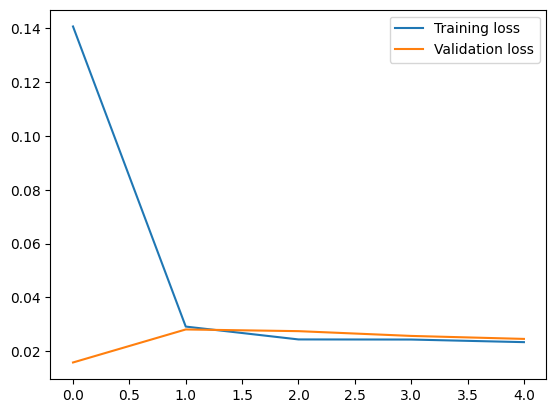

In [ ]:
# history = model1.fit(tf.convert_to_tensor(trainX), tf.convert_to_tensor(trainY), epochs=5, batch_size=16, validation_split=0.1, verbose=1)
history = model1.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)
# history = model1.fit(generator, epochs=50)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

**Predicting...**


In [ ]:
n_past = 14
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction)
print(predict_period_dates)


DatetimeIndex(['2016-01-31 20:44:00', '2016-02-01 20:44:00',
               '2016-02-02 20:44:00', '2016-02-03 20:44:00',
               '2016-02-04 20:44:00', '2016-02-05 20:44:00',
               '2016-02-06 20:44:00', '2016-02-07 20:44:00',
               '2016-02-08 20:44:00', '2016-02-09 20:44:00',
               '2016-02-10 20:44:00', '2016-02-11 20:44:00',
               '2016-02-12 20:44:00', '2016-02-13 20:44:00',
               '2016-02-14 20:44:00'],
              dtype='datetime64[ns]', freq='D')


In [ ]:
#Make prediction
prediction = model1.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 21ms/step


In [ ]:
#Perform inverse transformation to rescale back to original range
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
y_pred_future = min_max_scaler.inverse_transform(prediction_copies)[:,0]


In [ ]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
df_forecast = pd.DataFrame({'Datetime':np.array(forecast_dates), 'Total Carriageway Flow':y_pred_future})
df_forecast['Datetime']=pd.to_datetime(df_forecast['Datetime'])

In [ ]:
df_forecast

,Datetime,Total Carriageway Flow
0,2016-01-31,7.447754
1,2016-02-01,7.399411
2,2016-02-02,7.334157
3,2016-02-03,7.408832
4,2016-02-04,7.441817
5,2016-02-05,7.283734
6,2016-02-06,6.807653
7,2016-02-07,6.224062
8,2016-02-08,5.687587
9,2016-02-09,5.224506


In [ ]:
# Now lets open traffic dataset.
original = ogg[['datetime', ' Total Carriageway Flow']]
original['datetime']=pd.to_datetime(original['datetime'])
original = original.loc[original['datetime'] >= '2016-02-01 00:00:00']